## I try to impelementation latex symbole recognizer with framework PyTorch
* download dataset https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1

# import esential liberary for works
* convlutional nerual networks

In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import altair as alts
import numpy as np
import pandas as pd


In [140]:
print(torch.__version__)
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

2.5.1+cu121


device(type='cuda')

In [141]:
!wget https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1
# !tar xvzf HASYv2.tar.bz2

--2024-11-18 16:51:43--  https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/259444/files/HASYv2.tar.bz2 [following]
--2024-11-18 16:51:44--  https://zenodo.org/records/259444/files/HASYv2.tar.bz2
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 34597561 (33M) [application/octet-stream]
Saving to: ‘HASYv2.tar.bz2?download=1.2’

HASYv2.tar.bz2?down 100%[===================>]  32.99M  10.7MB/s    in 3.1s    

2024-11-18 16:51:48 (10.7 MB/s) - ‘HASYv2.tar.bz2?download=1.2’ saved [34597561/34597561]



In [142]:
!tar xvfj HASYv2.tar.bz2\?download\=1

Streaming output truncated to the last 5000 lines.
hasy-data/v2-134881.png
hasy-data/v2-120850.png
hasy-data/v2-156962.png
hasy-data/v2-143140.png
hasy-data/v2-144079.png
hasy-data/v2-164846.png
hasy-data/v2-36623.png
hasy-data/v2-42992.png
hasy-data/v2-53842.png
hasy-data/v2-87685.png
hasy-data/v2-103030.png
hasy-data/v2-02626.png
hasy-data/v2-27210.png
hasy-data/v2-158574.png
hasy-data/v2-79981.png
hasy-data/v2-29150.png
hasy-data/v2-132311.png
hasy-data/v2-148937.png
hasy-data/v2-145006.png
hasy-data/v2-118818.png
hasy-data/v2-114657.png
hasy-data/v2-80254.png
hasy-data/v2-93716.png
hasy-data/v2-133615.png
hasy-data/v2-105467.png
hasy-data/v2-103672.png
hasy-data/v2-62662.png
hasy-data/v2-146104.png
hasy-data/v2-124962.png
hasy-data/v2-18060.png
hasy-data/v2-14880.png
hasy-data/v2-32178.png
hasy-data/v2-10252.png
hasy-data/v2-35013.png
hasy-data/v2-146045.png
hasy-data/v2-153231.png
hasy-data/v2-01993.png
hasy-data/v2-160983.png
hasy-data/v2-00242.png
hasy-data/v2-136082.png
hasy-da

In [143]:
!ls -ls

total 113280
    4 drwxr-xr-x 12 1000 1000     4096 Jan 24  2017  classification-task
 5000 drwxr-xr-x  2 1000 1000  5120000 Jan 24  2017  hasy-data
 6864 -rw-r--r--  1 1000 1000  7024687 Jan 24  2017  hasy-data-labels.csv
   28 -rwxrwxr-x  1 1000 1000    26723 Jan 28  2017  hasy_tools.py
33788 -rw-r--r--  1 root root 34597561 Nov 18 15:03 'HASYv2.tar.bz2?download=1'
33788 -rw-r--r--  1 root root 34597561 Nov 18 16:24 'HASYv2.tar.bz2?download=1.1'
33788 -rw-r--r--  1 root root 34597561 Nov 18 16:51 'HASYv2.tar.bz2?download=1.2'
    4 -rw-rw-r--  1 1000 1000     2065 Jan 28  2017  README.txt
    4 drwxr-xr-x  1 root root     4096 Nov 14 14:25  sample_data
    8 -rw-rw-r--  1 1000 1000     7243 Jan 19  2017  symbols.csv
    4 drwxrwxr-x  2 1000 1000     4096 Jan 28  2017  verification-task


In [144]:
def get_num_line(file_name):
  '''count the number of lines in file '''
  counter = 0
  with open(file_name, 'r') as f:
    for lin in f:
      counter += 1
  return counter

In [145]:
def load_symbols(file_name):
  id2latex = dict()
  latex2id  = dict()
  f = open(file_name, 'r')
  next(f)
  id = 0
  for line in tqdm(f,total=get_num_line(file_name)):
    _,latex,_,_= line.split(',')
    if latex not in latex2id:
      latex2id[latex] = id
      id2latex[id] = latex
      id += 1
  return (id2latex, latex2id)

def load_data(label_file_name, latex2id):
  """ Reads the data file and create and return `data` and `labels` lists. """
  data = list()
  labels = list()
  f = open(label_file_name,'r')
  next(f)
  for line in tqdm(f, total=get_num_line(label_file_name)):
    image_path, sample_id, latex,_ = line.split(',')
    image = Image.open(os.path.join(image_path)).convert('L')
    inverted_image = Image.eval(image, lambda x: 255 - x)   # conver background
    img_array = np.asarray(inverted_image).astype('float32')
    data.append(img_array)
    labels.append(latex2id[latex])
  return data, labels









In [146]:
symbols_file_name = 'symbols.csv'
data_file_name = 'hasy-data-labels.csv'
id2latex, latex2id = load_symbols(symbols_file_name)
data, labels = load_data(data_file_name, latex2id)


100%|█████████▉| 168233/168234 [00:52<00:00, 3234.90it/s]


In [147]:
len(data), len(labels)

(168233, 168233)

\beta


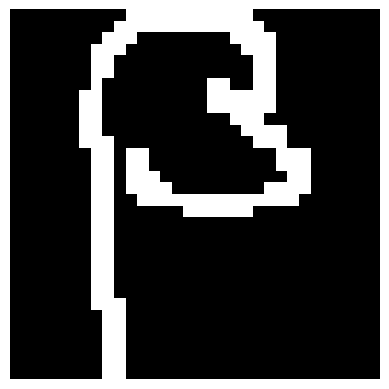

In [148]:
sample = 980
imge = Image.fromarray(data[sample])

plt.imshow(imge)
plt.axis('off')
#imge.save('geeks.jpg')
print(id2latex[labels[sample]])

In [149]:
num_samples = len(data)
num_classes = len(np.unique(labels))
name_classes = np.unique(labels)
num_classes , name_classes

(369,
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 17

In [150]:
train_data, test_data, train_label, test_label = train_test_split(data,labels, test_size=0.2, random_state=42)
hold_data, val_data, hold_label, val_label = train_test_split(train_data, train_label, test_size=0.1, random_state=42)

In [151]:
val_label[:6]

[40, 206, 99, 332, 289, 256]

In [152]:
# convert to tensor
train_data_tensor = torch.as_tensor(hold_data, dtype=torch.float32)
train_label_tensor = torch.as_tensor(hold_label, dtype=torch.float32)
test_data_tensor = torch.as_tensor(test_data, dtype=torch.float32)
test_label_tensor = torch.as_tensor(test_label, dtype=torch.float32)
val_data_tensor = torch.as_tensor(val_data, dtype=torch.float32)
val_label_tensor = torch.as_tensor(val_label, dtype=torch.float32)


In [153]:
train_data_tensor

tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [255., 255.,   0.,  ...,   0., 255., 255.],
         [255., 255.,   0.,  ...,   0., 255., 255.],
         [255.,   0.,   0.,  ...,   0.,   0., 255.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

In [154]:
print(train_data_tensor.shape, train_label_tensor.shape, test_data_tensor.shape, test_label_tensor.shape, '\n')
print(val_data_tensor.shape, val_label_tensor.shape)

torch.Size([121127, 32, 32]) torch.Size([121127]) torch.Size([33647, 32, 32]) torch.Size([33647]) 

torch.Size([13459, 32, 32]) torch.Size([13459])


In [155]:
train_data_tensor[0,:,:].shape


torch.Size([32, 32])

In [156]:
# convert 32, 32 to 1, 32, 32
train_data_t = train_data_tensor.unsqueeze(dim=1)
test_data_t = test_data_tensor.unsqueeze(dim=1)
val_data_t = val_data_tensor.unsqueeze(dim=1)
train_data_t.shape, test_data_t.shape, val_data_t.shape

(torch.Size([121127, 1, 32, 32]),
 torch.Size([33647, 1, 32, 32]),
 torch.Size([13459, 1, 32, 32]))

### Visualizing  our data

Image shape torch.Size([1, 32, 32])


Text(0.5, 1.0, '149.0')

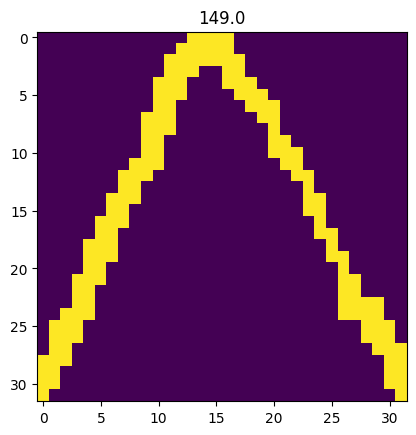

In [157]:
image, label = train_data_t[0], train_label_tensor[0]
print('Image shape', image.shape)  # chanels , height , width
plt.imshow(image.squeeze())
plt.title(label.item())

### we can turn the image into gray scale using the cmap

Text(0.5, 1.0, 'tensor(149.)')

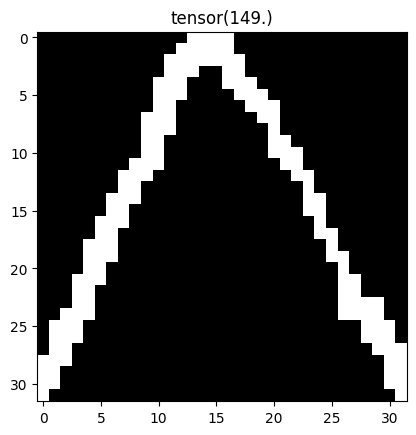

In [158]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

100%|██████████| 16/16 [00:00<00:00, 93.35it/s]


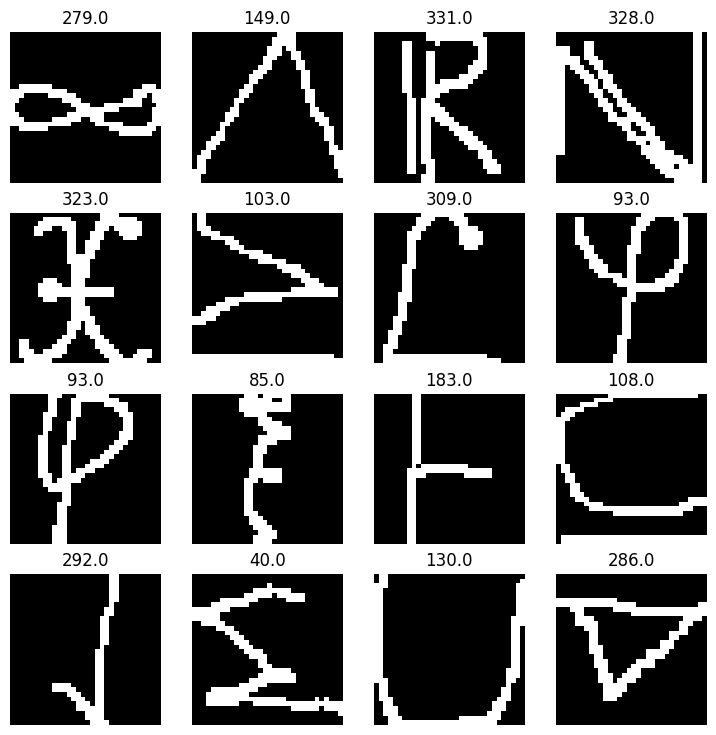

In [159]:
# plot more image
from tqdm import tqdm
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row , col = 4, 4
for i in tqdm(range(1, row * col + 1)):
  rand_idx = torch.randint(0, len(train_data_t), size=[1]).item()
  img , label = train_data_t[rand_idx], train_label_tensor[rand_idx]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(label.item())
  plt.axis(False)


# 2.Prepare DataLoader
* The next stepis to prepare it with a TensorDataset
and DataLoader

In [160]:
train_set = TensorDataset(train_data_t, train_label_tensor)
test_set = TensorDataset(test_data_t, test_label_tensor)
val_set = TensorDataset(val_data_t, val_label_tensor)


### Initializing hyperparameters
* batches or mini-baches
* learning rate  step for move
* number of epochs

In [161]:
batch_size = 64
learning_rate = 0.0001
num_epochs = 20


### DataLoader
* The  DataLoader does what you think it might do
* It helps load data into a model
* For training and for inference.

In [162]:
# DataLoader
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_set,batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False )

In [163]:
# Let's check out what we've created
print(f'Dataloaders: {train_loader, test_loader}')
print(f'Length of train dataloader: {len(train_loader)} batches of {batch_size}')
print(f'Length of val dataloader: {len(val_loader)} batches of {batch_size}')
print(f'Length of test dataloader: {len(test_loader)} batches of {batch_size}')


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b104e98e3e0>, <torch.utils.data.dataloader.DataLoader object at 0x7b104e98cdf0>)
Length of train dataloader: 1893 batches of 64
Length of val dataloader: 211 batches of 64
Length of test dataloader: 526 batches of 64


In [164]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

Image size : torch.Size([1, 32, 32])
label: 143.0, label size : torch.Size([])


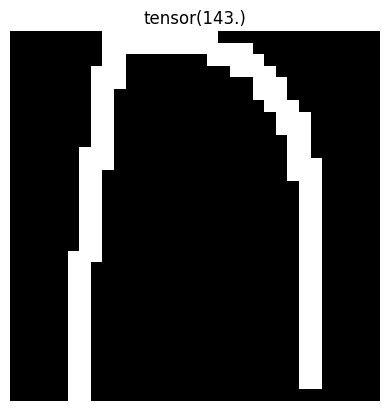

In [165]:
# Show a sample
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img , label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(label)
plt.axis('Off');
print(f'Image size : {img.shape}')
print(f'label: {label.item()}, label size : {label.shape}')

## create a CNN class

In [166]:
class CNNModel(nn.Module):
  def __init__(self, input_features, num_classes):
    super(CNNModel, self).__init__()
    self.layer1 = nn.Sequential(
        # 32x32x1 --> 32x32x64
        nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=(3,3), stride=(1,1), padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 32x32x64 --> 16x16x128
        nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=(3,3), stride=(1,1), padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),
        nn.Dropout(p=0.5)
    )
    # 16x16x128 --> 8x8x128
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128 , kernel_size=(5,5), stride=(1,1), padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    )
    # 8x8x128
    self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * (input_features // 4)* (input_features//4) , 128),
        nn.Dropout(p=0.5)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(128,128),
        nn.Dropout(p=0.5)
    )

    self.fc3 = nn.Linear(128, num_classes)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [167]:
model = CNNModel(input_features=32 ,num_classes=num_classes)
model

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): Dropout(p=0.5, inplace=False)
  )


In [168]:
img, label = next(iter(train_loader))

In [169]:
img.shape


torch.Size([64, 1, 32, 32])

In [170]:
img.dtype

torch.float32

In [171]:
img = img.float()
img.shape

torch.Size([64, 1, 32, 32])

In [172]:
y_hat = model(img)

In [173]:
y_hat.shape

torch.Size([64, 369])

# loss

In [174]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [175]:
loss = loss_fn(y_hat, label.long())
loss

tensor(6.0996, grad_fn=<NllLossBackward0>)

In [176]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# from adopt import ADOPT
# optimizer = ADOPT(model.parameters(), lr=1e-3)

In [177]:
num_epochs = 40
step_size = len(train_loader)
train_acc_hist , valid_acc_hist = [], []
train_loss_hist, valid_loss_hist = [], []
best_loss_valid = 10000

for epoch in range(num_epochs):

  mean_loss_train, mean_loss_valid = 0, 0
  mean_acc_train , mean_acc_valid = 0, 0

  for idx, (x_batch, y_batch) in enumerate(train_loader):
    model.train()

    # convert to one dim
    y_batch = y_batch.to(device)
    x_batch = x_batch.to(device)
    # model
    model.to(device)
    y_hat = model(x_batch)
    # print(y_hat.shape)

    # loss
    loss = loss_fn(y_hat, y_batch.long())

    # gradient
    loss.backward()

    # updat
    optimizer.step()
    optimizer.zero_grad()

    mean_loss_train += loss.item() * len(x_batch)
    mean_acc_train += (y_hat.argmax(dim=1)==y_batch).sum().item()

  mean_loss_train = mean_loss_train/len(train_set)
  mean_acc_train = mean_acc_train /len(train_set)

  train_loss_hist.append(mean_loss_train)
  train_acc_hist.append(mean_acc_train)

  # valid
  model.eval()
  with torch.no_grad():
    for x_batch, y_batch in val_loader:
      y_batch = y_batch.to(device)
      x_batch = x_batch.to(device)
      y_hat = model(x_batch)
      loss =loss_fn(y_hat, y_batch.long())
      mean_loss_valid += loss.item() * len(x_batch)
      mean_acc_valid += (y_hat.argmax(dim=1)==y_batch).sum().item()

    mean_loss_valid = mean_loss_valid/len(val_set)
    mean_acc_valid = mean_acc_valid /len(val_set)

    valid_loss_hist.append(mean_loss_valid)
    valid_acc_hist.append(mean_acc_valid)

  if epoch % 5 == 0:
    print(
        f" Epoch: [{epoch}/{num_epochs}] "
        # f" step: [{idx}/{step_size}]"
        f" Loss train: {mean_loss_train:.2f}"
        f" Accuracy train: {mean_acc_train:.2f}"
        f" Loss valid: {mean_loss_valid:.2f}"
        f" Accuracy valid: {mean_acc_valid:.2f}"
        )

  # # this section save best loss
  # if mean_loss_valid < best_loss_valid:
  #   torch.save(model, 'best-model.pt')
  #   best_loss_valid = mean_loss_valid
  #   print('save model!')
  #   print()




 Epoch: [0/40]  Loss train: 3.49 Accuracy train: 0.33 Loss valid: 1.64 Accuracy valid: 0.63
 Epoch: [5/40]  Loss train: 1.10 Accuracy train: 0.71 Loss valid: 0.69 Accuracy valid: 0.80
 Epoch: [10/40]  Loss train: 0.88 Accuracy train: 0.76 Loss valid: 0.61 Accuracy valid: 0.82
 Epoch: [15/40]  Loss train: 0.78 Accuracy train: 0.78 Loss valid: 0.59 Accuracy valid: 0.82
 Epoch: [20/40]  Loss train: 0.72 Accuracy train: 0.79 Loss valid: 0.57 Accuracy valid: 0.83
 Epoch: [25/40]  Loss train: 0.68 Accuracy train: 0.80 Loss valid: 0.57 Accuracy valid: 0.83
 Epoch: [30/40]  Loss train: 0.64 Accuracy train: 0.80 Loss valid: 0.56 Accuracy valid: 0.83
 Epoch: [35/40]  Loss train: 0.61 Accuracy train: 0.81 Loss valid: 0.57 Accuracy valid: 0.83


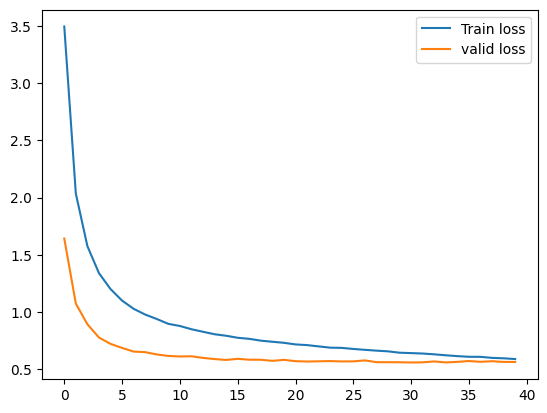

In [178]:
plt.plot(torch.arange(num_epochs), train_loss_hist)
plt.plot(torch.arange(num_epochs), valid_loss_hist)
plt.legend(['Train loss', 'valid loss'])
plt.show()

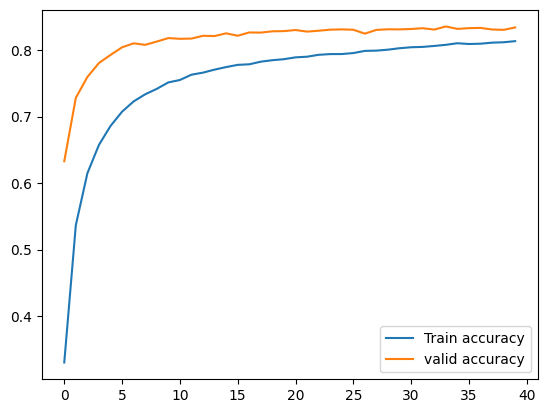

In [179]:
# accuracy
plt.plot(torch.arange(num_epochs), train_acc_hist)
plt.plot(torch.arange(num_epochs), valid_acc_hist)
plt.legend(['Train accuracy', 'valid accuracy'])
plt.show()

In [180]:
! pip install visualtorch

## Visulizing layers for model

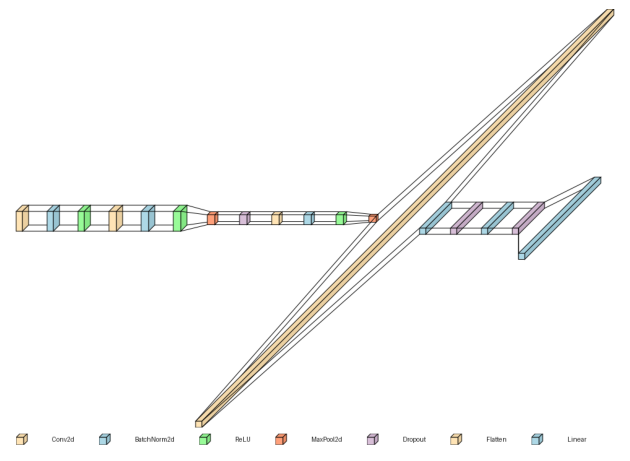

In [200]:

import visualtorch

input_shape = (64, 1, 32, 32)
img = visualtorch.layered_view(model.to('cpu'), input_shape=input_shape, draw_volume=True, legend=True, one_dim_orientation="x",
    spacing=40,)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

## Calculate accuracy for test data

In [193]:
from tqdm import tqdm
mean_acc_test = 0
with torch.inference_mode():
  for x_batch, y_batch in tqdm(test_loader):
    model.to(device)
    y_batch = y_batch.to(device)
    x_batch = x_batch.to(device)
    y_hat = model(x_batch)
    # loss =loss_fn(y_hat, y_batch.long())
    # mean_loss_valid += loss.item() * len(x_batch)
    mean_acc_test += (y_hat.argmax(dim=1)==y_batch).sum().item()
  mean_acc_test = mean_acc_test /len(test_set)
mean_acc_test



100%|██████████| 526/526 [00:02<00:00, 180.87it/s]


0.8350521591820965